In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, initializers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
import joblib


In [2]:
dataset = ''

hr_file = f"D:/Ankit work/irs_2_users/data{dataset}/hr.csv"
hd_file = f"D:/Ankit work/irs_2_users/data{dataset}/hd.csv"
G_file = f"D:/Ankit work/irs_2_users/data{dataset}/G.csv"
Omega_file = f"D:/Ankit work/irs_2_users/data{dataset}/omega.csv"

W_file = f"D:/Ankit work/irs_2_users/data{dataset}/W_pred.csv"
theta_file = f"D:/Ankit work/irs_2_users/data{dataset}/theta.csv"

scaler_X_file = "D:/Ankit work/irs_2_users/notebooks/w_followed_by_theta/scaler_X.pkl"
scaler_Y_file = "D:/Ankit work/irs_2_users/notebooks/w_followed_by_theta/scaler_Y.pkl"
modal_save_file = "D:/Ankit work/irs_2_users/notebooks/w_followed_by_theta/my_trained_model.keras"

In [3]:
# Load input datasets
hr = pd.read_csv(hr_file, header=None)
hd = pd.read_csv(hd_file, header=None)
G = pd.read_csv(G_file, header=None)
Omega = pd.read_csv(Omega_file, header=None)
W = pd.read_csv(W_file, header=None)

# Load output datasets
Theta = pd.read_csv(theta_file, header=None)

# Concatenate input datasets (hr, hd, G) and output datasets (W, theta)
X = pd.concat([hr, hd, G, Omega, W], axis=1)
Y = pd.concat([Theta], axis=1)

# Standardize input data
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Optionally, scale output data (depending on your needs)
scaler_Y = StandardScaler()
Y_scaled = scaler_Y.fit_transform(Y)

print("X shape: ", X.shape)
print("Y shape: ", Y.shape)


X shape:  (555600, 636)
Y shape:  (555600, 100)


In [4]:
# Manually shuffle the dataset using pandas
X_shuffled = pd.DataFrame(X_scaled).sample(frac=1, random_state=42).reset_index(drop=True)
Y_shuffled = pd.DataFrame(Y_scaled).sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into train, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X_scaled, Y_scaled, test_size=0.4, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

del hr, hd, G, Omega, Theta, X, Y, W, X_scaled, Y_scaled

print(X_train.shape, Y_train.shape)

(333360, 636) (333360, 100)


In [11]:
l2_lambda = 0.00000001
dropout_rate = 0.001  # Set the dropout rate (0.2 = 20%)

In [18]:
# Define the neural network
model = models.Sequential()

# Input layer (shape based on input features)
model.add(layers.InputLayer(shape=(X_train.shape[1],)))

# Hidden layers
model.add(layers.Dense(2048, kernel_initializer=initializers.HeNormal(), kernel_regularizer=regularizers.l2(l2_lambda)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(dropout_rate)) 

model.add(layers.Dense(1024, kernel_initializer=initializers.HeNormal(), kernel_regularizer=regularizers.l2(l2_lambda)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(dropout_rate)) 

model.add(layers.Dense(512, kernel_initializer=initializers.HeNormal(), kernel_regularizer=regularizers.l2(l2_lambda)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(dropout_rate)) 

model.add(layers.Dense(512, kernel_initializer=initializers.HeNormal(), kernel_regularizer=regularizers.l2(l2_lambda)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(dropout_rate)) 

model.add(layers.Dense(256, kernel_initializer=initializers.HeNormal(), kernel_regularizer=regularizers.l2(l2_lambda)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(dropout_rate))  # Dropout with dropout_rate probability

# Output layer
model.add(layers.Dense(Y_train.shape[1]))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [19]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Create the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

In [20]:
train_count = 1

In [21]:
history = model.fit(X_train, Y_train, epochs=100, validation_data=(X_val, Y_val), batch_size=128, shuffle=True, callbacks=[early_stopping])

Epoch 1/100
2605/2605 ━━━━━━━━━━━━━━━━━━━━ 72s 27ms/step - loss: 0.9806 - mae: 0.8744 - val_loss: 0.6274 - val_mae: 0.6495
Epoch 2/100
2605/2605 ━━━━━━━━━━━━━━━━━━━━ 111s 43ms/step - loss: 0.5466 - mae: 0.5980 - val_loss: 0.4022 - val_mae: 0.4917
Epoch 3/100
2605/2605 ━━━━━━━━━━━━━━━━━━━━ 164s 63ms/step - loss: 0.3780 - mae: 0.4812 - val_loss: 0.3406 - val_mae: 0.4445
Epoch 4/100
2605/2605 ━━━━━━━━━━━━━━━━━━━━ 181s 70ms/step - loss: 0.3237 - mae: 0.4409 - val_loss: 0.3106 - val_mae: 0.4195
Epoch 5/100
2605/2605 ━━━━━━━━━━━━━━━━━━━━ 180s 69ms/step - loss: 0.2949 - mae: 0.4182 - val_loss: 0.2916 - val_mae: 0.4037
Epoch 6/100
2605/2605 ━━━━━━━━━━━━━━━━━━━━ 199s 68ms/step - loss: 0.2757 - mae: 0.4029 - val_loss: 0.2794 - val_mae: 0.3929
Epoch 7/100
2605/2605 ━━━━━━━━━━━━━━━━━━━━ 170s 65ms/step - loss: 0.2625 - mae: 0.3921 - val_loss: 0.2683 - val_mae: 0.3836
Epoch 8/100
2605/2605 ━━━━━━━━━━━━━━━━━━━━ 165s 63ms/step - loss: 0.2504 - mae: 0.3819 - val_loss: 0.2614 - val_mae: 0.3774
Epoch 9/1

In [22]:

# Evaluate the model on training, validation, and test sets
train_loss, train_mae = model.evaluate(X_train, Y_train)
val_loss, val_mae = model.evaluate(X_val, Y_val)
test_loss, test_mae = model.evaluate(X_test, Y_test)

# Get model predictions for calculating MAPE
# train_pred = model.predict(X_train)
# val_pred = model.predict(X_val)
# test_pred = model.predict(X_test)


# Create a remark about model performance (e.g., overfitting or good fit)
if train_loss < val_loss and train_loss < test_loss:
    remark = "Possible overfitting detected."
elif val_loss <= test_loss:
    remark = "Good fit."
else:
    remark = "Model underfits the data."
    


10418/10418 ━━━━━━━━━━━━━━━━━━━━ 74s 7ms/step - loss: 0.1448 - mae: 0.2745
3473/3473 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 0.2018 - mae: 0.3164
3473/3473 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 0.2003 - mae: 0.3158


In [23]:

import sys
import numpy as np

# Assuming you already have your model trained, and 'history' stores training info
# Redirect model summary to a file
with open('D:/Ankit work/irs_2_users/notebooks/w_followed_by_theta/model_performance_log.txt', "a", encoding="utf-8") as f:
    f.write('\n*******************************************************************************************************\n')
    f.write(f"Remark: {remark}\n")
    f.write(f"He intialized , L2 Regularized ({l2_lambda}), dropout({dropout_rate}), early stop (20), batch normalization\n" )
    # Save the number of hidden layers and neurons per layer
    # model.summary(print_fn=lambda x: f.write(x + "\n"))
    
    # Save the number of hidden layers and neurons per layer
    hidden_layers = [layer for layer in model.layers if isinstance(layer, tf.keras.layers.Dense) and layer != model.layers[-1]]  # exclude output layer
    f.write("\nNumber of hidden layers: {}\n".format(len(hidden_layers)))
    for i, layer in enumerate(hidden_layers):
        f.write("Layer {}: {} neurons\n".format(i + 1, layer.units))  # 'units' gives the number of neurons

    f.write("\nTraining loss: {}\n".format(train_loss))
    f.write("Validation loss: {}\n".format(val_loss))
    f.write("Test loss: {}\n".format(test_loss))
    f.write("\n")
    
    f.write("\nTraining and Validation Losses for each epoch:\n")
    for epoch in range(len(history.history['loss'])):
        if(epoch % 10 == 0):
            f.write("Epoch {}: Training loss = {:.4f}, Validation loss = {:.4f}\n".format(
                epoch + 1,
                history.history['loss'][epoch],
                history.history['val_loss'][epoch]
            ))
            
    f.write('*******************************************************************************************************\n')


### Saving Modal

In [24]:
# Save the trained model to a file (HDF5 format or TensorFlow SavedModel format)
# model.save(modal_save_file)  # Save as HDF5

# Save the scaler to a file
joblib.dump(scaler_X, scaler_X_file)
joblib.dump(scaler_Y, scaler_Y_file)


['D:/Ankit work/irs_2_users/notebooks/w_followed_by_theta/scaler_Y.pkl']

### Loading Modal

In [53]:
from tensorflow.keras.models import load_model
from tensorflow import keras

# Load the model
loaded_model = keras.models.load_model(modal_save_file)

# Load the saved scaler
scaler_X_loaded = joblib.load(scaler_X_file)
scaler_Y_loaded = joblib.load(scaler_Y_file)


In [26]:
loaded_model = model
scaler_X_loaded = scaler_X
scaler_Y_loaded = scaler_Y

In [27]:
loaded_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                     │ (None, 2048)                │       1,304,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_20 (Activation)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_21 (Activation)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_22 (Activation)           │ (None, 256)                 │              

 Total params: 13,076,526 (49.88 MB)

 Trainable params: 4,355,940 (16.62 MB)

 Non-trainable params: 8,704 (34.00 KB)

 Optimizer params: 8,711,882 (33.23 MB)

### PREDICTION

In [29]:
hr_testing_file = f"D:/Ankit work/irs_2_users/testing_data/hr.csv"
hd_testing_file = f"D:/Ankit work/irs_2_users/testing_data/hd.csv"
G_testing_file = f"D:/Ankit work/irs_2_users/testing_data/G.csv"
Omega_testing_file = f"D:/Ankit work/irs_2_users/testing_data/omega.csv"
W_pred_testing_file = f"D:/Ankit work/irs_2_users/notebooks/only_w/testing_data/only_w_pred.csv"

# Load input datasets
hr_testing = pd.read_csv(hr_testing_file, header=None)
hd_testing = pd.read_csv(hd_testing_file, header=None)
G_testing = pd.read_csv(G_testing_file, header=None)
Omega_testing = pd.read_csv(Omega_testing_file, header=None)
W_pred_testing = pd.read_csv(W_pred_testing_file, header=None)

# Concatenate input datasets (hr, hd, G) and output datasets (W, theta)
X_testing = pd.concat([hr_testing, hd_testing, G_testing, Omega_testing, W_pred_testing], axis=1)

X_scaled_testing = scaler_X_loaded.transform(X_testing)
print(X_testing.shape)
print(X_scaled_testing.shape)


(100, 636)
(100, 636)


In [30]:
# Let's assume 'new_data_batch' is a batch of new inputs (e.g., multiple samples).
new_data_batch = X_scaled_testing

# Make predictions for the batch
scaled_predictions = loaded_model.predict(new_data_batch)
predictions = scaler_Y_loaded.inverse_transform(scaled_predictions)

# Print the predictions
print("Predictions for the batch of inputs:", predictions.shape)

# Evaluate the model on test data
test_loss, test_mae = loaded_model.evaluate(X_test, Y_test)

print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predictions for the batch of inputs: (100, 100)
3473/3473 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.2003 - mae: 0.3158
Test Loss: 0.20049338042736053
Test MAE: 0.3159479796886444


In [31]:
import pandas as pd

# Assuming Y_pred is a NumPy array
# If it's not, convert it to a NumPy array: Y_pred = np.array(Y_pred)

# Convert to DataFrame
Y_pred_df = pd.DataFrame(predictions)  # Add appropriate column name(s)

# Save to CSV
Y_pred_df.to_csv('D:/Ankit work/irs_2_users/notebooks/w_followed_by_theta/testing_data/theta_after_w_pred.csv', index=False, header=False)  # index=False to avoid adding row numbers to the file


(100, 100) (100, 16)


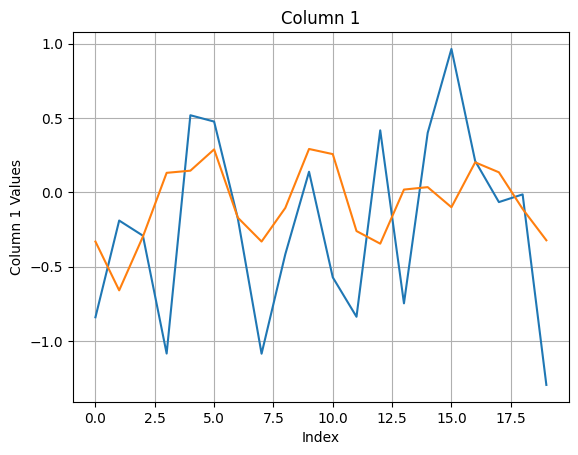

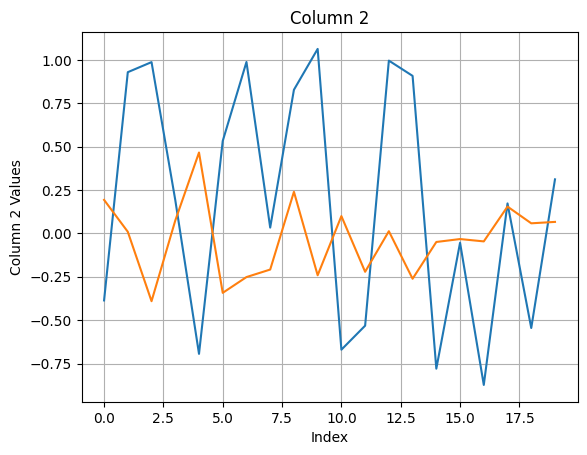

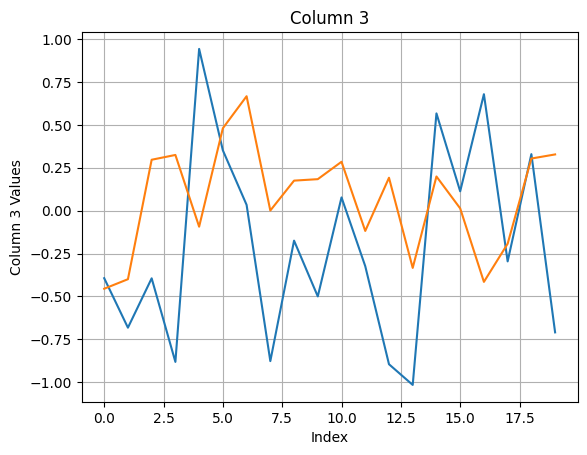

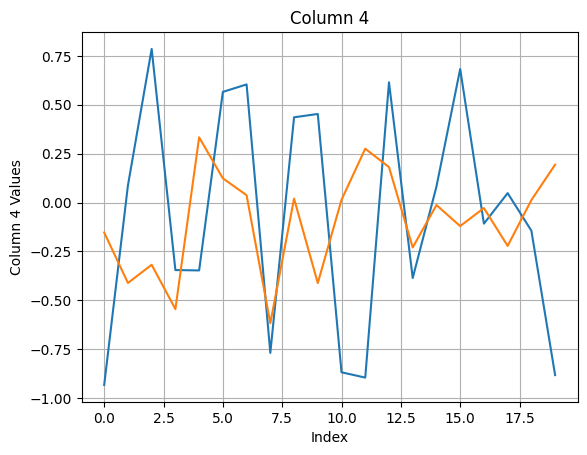

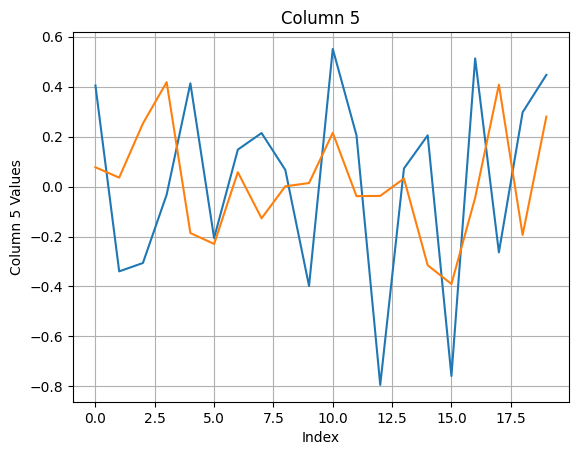

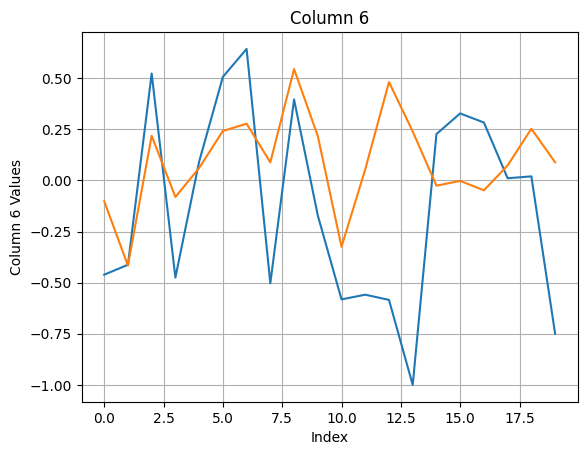

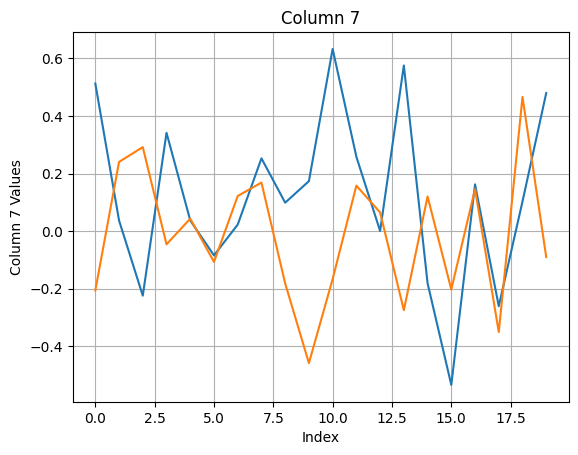

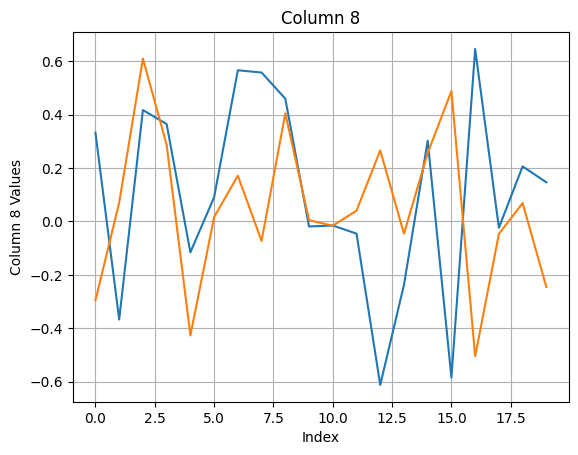

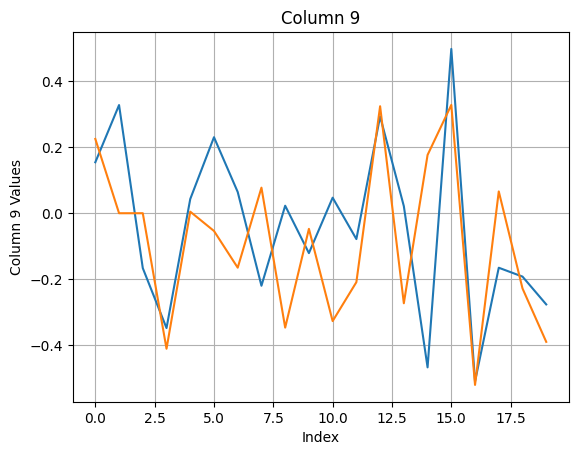

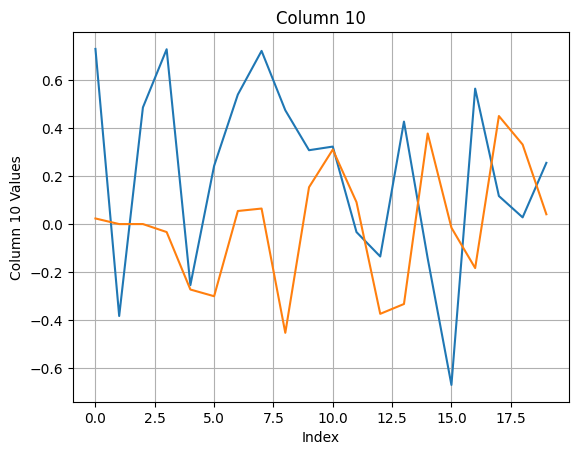

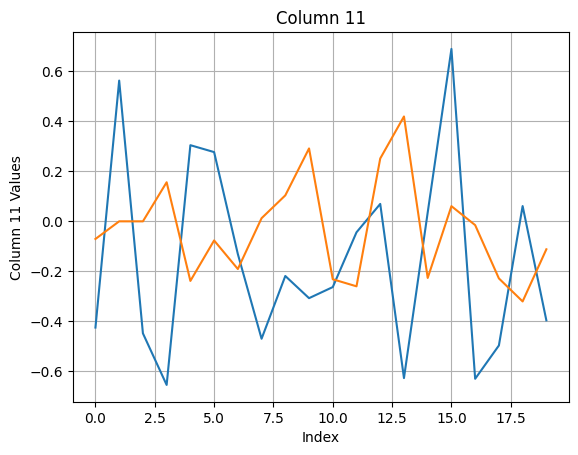

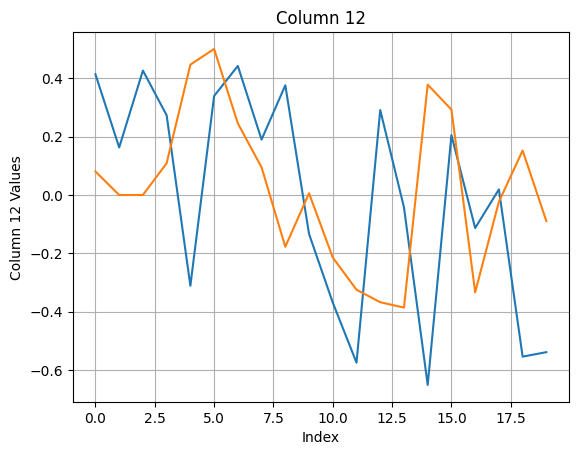

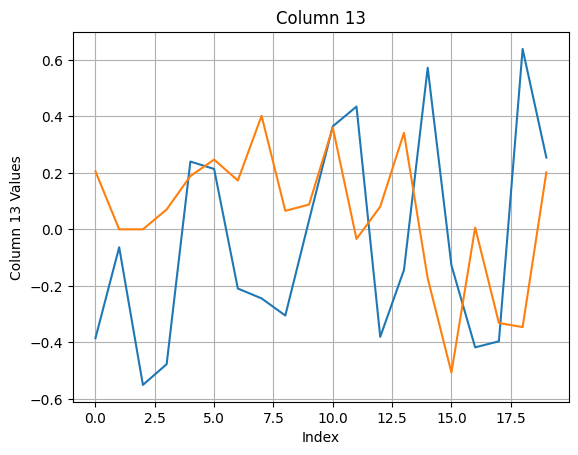

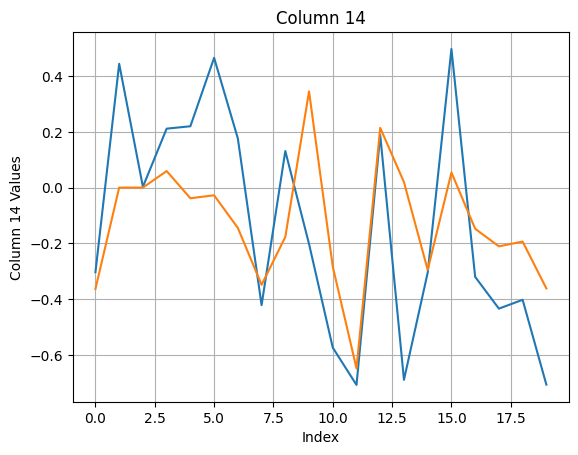

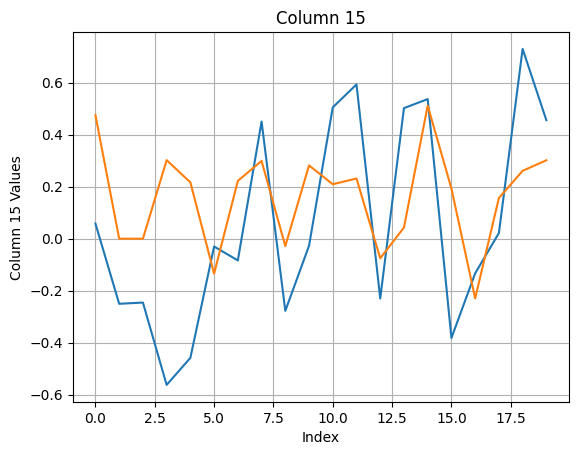

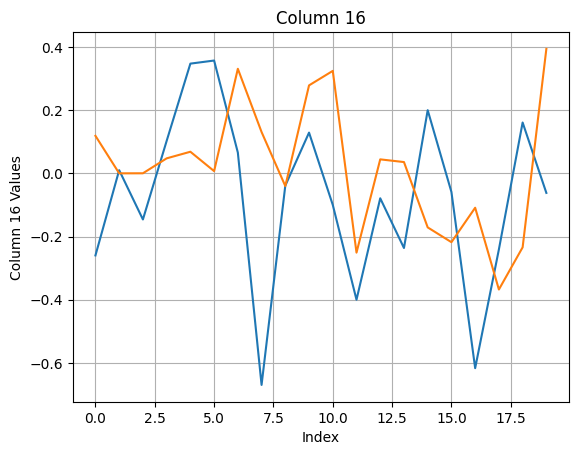

KeyError: 16

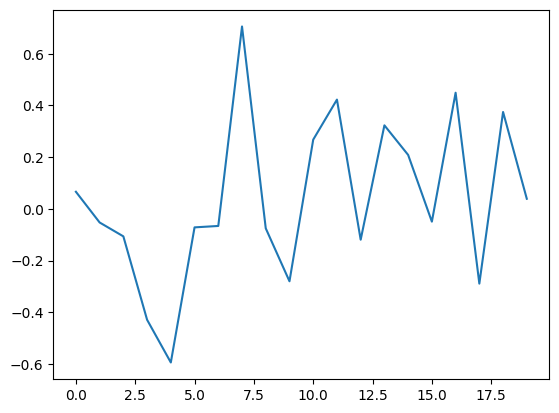

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file without a header
df = pd.read_csv('D:/Ankit work/irs_2_users/notebooks/w_followed_by_theta/testing_data/theta_after_w_pred.csv', header=None)
df2 = pd.read_csv('D:/Ankit work/irs_2_users/testing_data/W.csv', header=None)

print(df.shape, df2.shape)
# Plot each column separately
for i in range(df.shape[1]):  # df.shape[1] gives the number of columns
    plt.figure()  # Create a new figure for each plot
    plt.plot(df[i][:20])  # Plot the i-th column
    plt.plot(df2[i][:20])  # Plot the i-th column
    plt.title(f'Column {i+1}')  # Add title for clarity
    plt.xlabel('Index')  # X-axis label
    plt.ylabel(f'Column {i+1} Values')  # Y-axis label
    plt.grid(True)  # Enable grid
    plt.show()  # Show the plot
